In [1]:
from brian2 import *
from SPN import NeuronModel
from simulation import Simulation
from synapse import SynapseModel, connect

In [2]:
from brian2tools import *
import matplotlib.pyplot as plt
import random
import numpy as np
from brian2.units import *
from neuron import h, gui
from brian2 import ms, mV, pA, pF, siemens, amp, second, NeuronGroup, defaultclock, run
import json
import numpy as np

--No graphics will be displayed.


In [3]:
def main():
    # Define parameters for NeuronModel
    N = 1000
    params = {
        'v': -80 * mV,
        'u': 0 * mV / ms,
        'a': 0.01 / ms,
        'b': -20 / ms,
        'c': -55 * mV,
        'C': 15.2 * pF,
        'd': 91 * mV / ms,
        'k': 1,
        'vr': -80 * mV,
        'vt': -29.7 * mV,
        'vpeak': 40 * mV,
        'I': 0 * nA,
        'Dop1': 0.5,
        'Dop2': 0.5,
        'KAPA': 0.0289,
        'ALPHA': 0.032
    }

    # Create input current pattern: constant then step change
    I_base = 100 * nA
    I_step = 150 * nA
    I_pattern_values = np.concatenate((I_base * np.ones(int(50/ms/defaultclock.dt)),
                                       I_step * np.ones(int(50/ms/defaultclock.dt)))) * nA

    # Create NeuronModel instance
    neuron_model = NeuronModel(N, params)

    # Create Simulation instance
    sim = Simulation(neuron_model)

    # Run the simulation for 100 ms
    sim.run(duration=100 * ms)

INFO:root:creating /var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_wll459cs/var
INFO:root:creating /var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_wll459cs/var/folders
INFO:root:creating /var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_wll459cs/var/folders/tj
INFO:root:creating /var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_wll459cs/var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn
INFO:root:creating /var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_wll459cs/var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T
INFO:root:creating /var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_wll459cs/var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_wll459cs
INFO:root:arm64-apple-darwin20.0.0-clang -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /opt/anaconda3/envs/brain/include -arch arm64 -fPIC -O2 -isystem /opt/anaconda3/envs/brain/include -arch

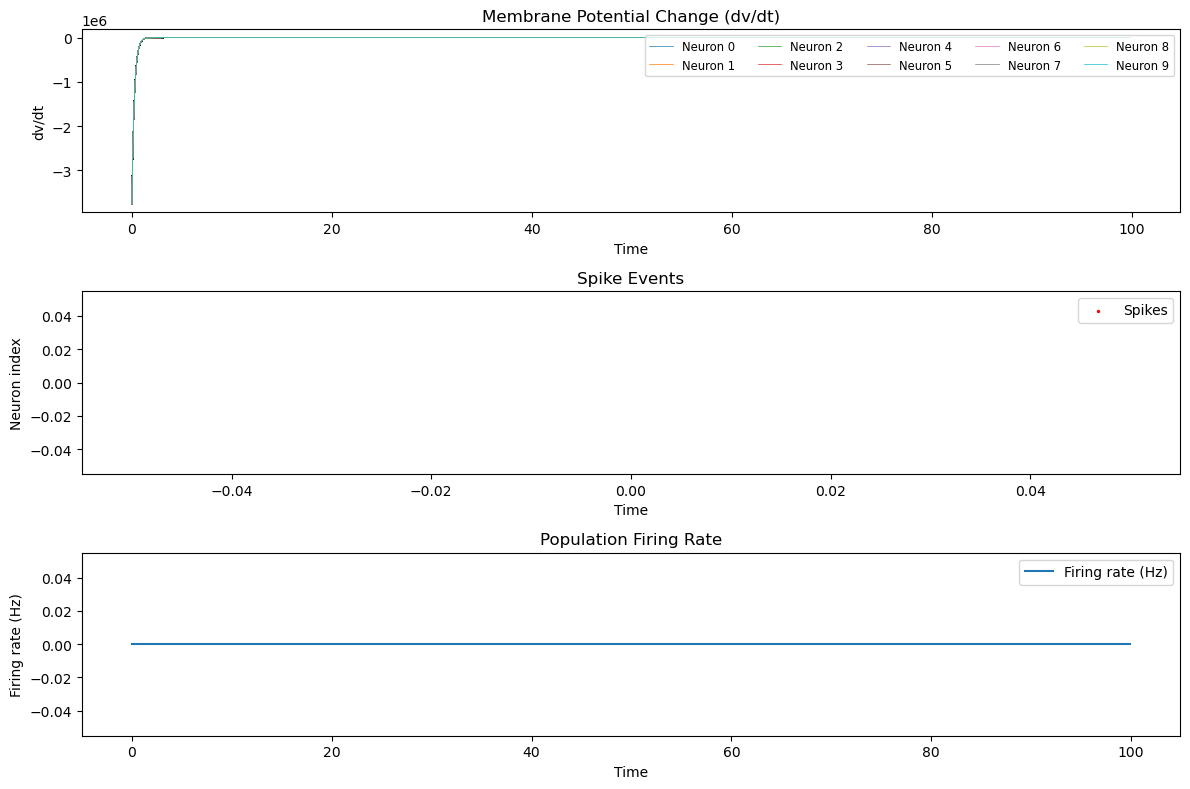

In [4]:
if __name__ == '__main__':
    main()

INFO       The synaptic equation for the variable g_ampa does not specify whether it should be integrated at every timestep ('clock-driven') or only at spiking events ('event-driven'). It will be integrated at every timestep which can slow down your simulation unnecessarily if you only need the values of this variable whenever a spike occurs. Specify the equation as clock-driven explicitly to avoid this warning. [brian2.synapses.synapses.clock_driven]
INFO       The synaptic equation for the variable g_gaba_FSI does not specify whether it should be integrated at every timestep ('clock-driven') or only at spiking events ('event-driven'). It will be integrated at every timestep which can slow down your simulation unnecessarily if you only need the values of this variable whenever a spike occurs. Specify the equation as clock-driven explicitly to avoid this warning. [brian2.synapses.synapses.clock_driven]
INFO       The synaptic equation for the variable g_gaba_MSN does not specify whethe

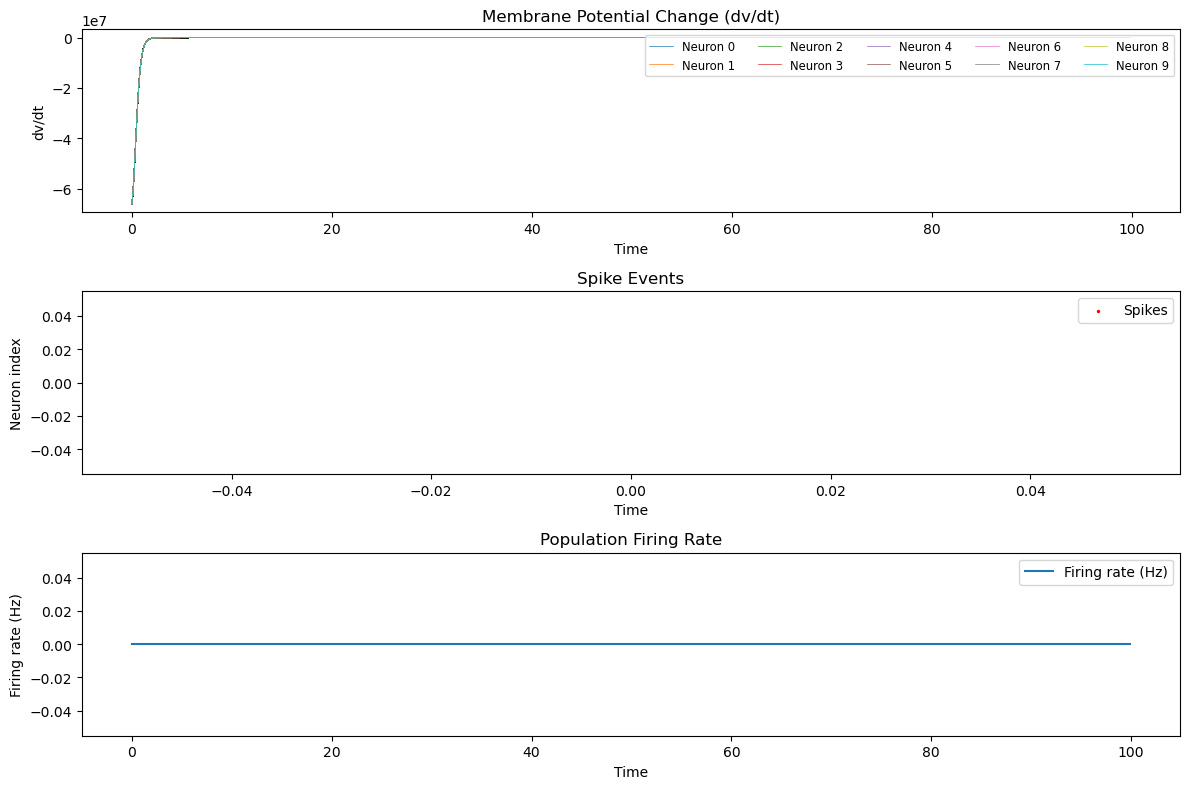

In [3]:
from brian2 import *
from SPN import NeuronModel
from synapse import SynapseModel, connect
import numpy as np
import matplotlib.pyplot as plt

def main():
    # Parameters for the neuron model
    N = 1000
    params = {
        'v': -80 * mV,
        'u': 0 * mV / ms,
        'a': 0.01 / ms,
        'b': -20 / ms,
        'c': -55 * mV,
        'd': 91 * mV / ms,
        'k': 1,
        'vr': -80 * mV,
        'vt': -29.7 * mV,
        'vpeak': 40 * mV,
        'I': 0 * nA,
        'Dop1': 0.5,
        'Dop2': 0.5,
        'C': 15.2 * pF,
        'KAPA': 1,
        'ALPHA': 1,
    }

    # Create neuron models
    dSPN = NeuronModel(N, params)
    iSPN = NeuronModel(N, params)

    # Define synapse equations
    syn_eqs_SPN = '''
    B = 1.0 / (1.0 + (0.28) * exp(-0.062 * v / mV)) : 1
    Iampa = G_ampa * g_ampa * (E_ampa - v) : amp
    Inmda = B * G_nmda * g_nmda * (E_nmda - v) : amp
    Igaba_MSN = G_gaba_MSN * g_gaba_MSN * (E_gaba - v) : amp
    Igaba_FSI = G_gaba_FSI * g_gaba_FSI * (E_gaba - v) : amp
    dg_ampa / dt = -g_ampa / tau_ampa : siemens
    dg_nmda / dt = -g_nmda / tau_nmda : siemens
    dg_gaba_MSN / dt = -g_gaba_MSN / tau_gaba : siemens
    dg_gaba_FSI / dt = -g_gaba_FSI / tau_gaba : siemens
    tau_ampa : second
    tau_nmda : second
    tau_gaba : second
    E_ampa : volt
    E_nmda : volt
    E_gaba : volt
    G_ampa : 1
    G_nmda : 1
    G_gaba_MSN : 1
    G_gaba_FSI : 1
    '''

    connect_probability = {
        'pSP1SP1': 0.1,
        'pSP1SP2': 0.1,
        'pSP2SP1': 0.1,
        'pSP2SP2': 0.1,
    }

    # Create synapses
    syn_dSPN_dSPN = connect(dSPN.neurons, dSPN.neurons, syn_eqs_SPN, p_connect=connect_probability['pSP1SP1'], pre="g_gaba_MSN += 0.4 * nS")
    syn_dSPN_iSPN = connect(dSPN.neurons, iSPN.neurons, syn_eqs_SPN, p_connect=connect_probability['pSP1SP2'], pre="g_gaba_MSN += 1.0 * nS")
    syn_iSPN_dSPN = connect(iSPN.neurons, dSPN.neurons, syn_eqs_SPN, p_connect=connect_probability['pSP2SP1'], pre="g_gaba_MSN += 1.2 * nS")
    syn_iSPN_iSPN = connect(iSPN.neurons, iSPN.neurons, syn_eqs_SPN, p_connect=connect_probability['pSP2SP2'], pre="g_gaba_MSN += 1.0 * nS")

    # Setup and run the simulation
    from simulation import Simulation
    sim = Simulation(dSPN)
    sim.run(100 * ms)

if __name__ == '__main__':
    main()
